# We're going to try fitting a full asymptotic relation to some simulated data


I'm going to inject a glitch signal and see how it goes...

**Result:** Using a decentralised parameterisation results in significant slowdown (of the order of 2x, 3x) of the fit. Using a regular centralised parameterisation results in large numbers of divergences (as you'd expect). On investigation of the divergences, none of them bias us away from the true value, and all truth values are returned from the fit. I'm happy to retain divergences for now.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

import pymc3 as pm
import arviz

## Build the model

In [27]:
class model():
    def __init__(self, f, n0_, n1_, n2_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        
    def epsilon(self, i):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.sqr(tt.cos(i)))
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sqr(tt.sin(i)))
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * tt.sqr((3. * tt.sqr(tt.cos(i)) - 1.)))
        eps2 = tt.set_subtensor(eps2[1], (3./8.) * tt.sqr(tt.sin(2*i)))
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        return eps
            
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/tt.sqr(w)*tt.sqr((self.f - freq)))
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        eps = self.epsilon(i)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
               
        #Create the model
        self.mod = self.modes + b
        if theano:
            return self.mod
        else:
            return self.mod.eval()

    # Small separations are fractional
    def asymptotic(self, n, numax, deltanu, alpha, epsilon, d=0.): 
        nmax = (numax / deltanu) - epsilon
        curve = (alpha/2.)*(n-nmax)*(n-nmax)
        return (n + epsilon + d + curve)

    def f0(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, deltanu, alpha, epsilon, 0.)
    
    def f1(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n1, numax, deltanu, alpha, epsilon, d01)
    
    def f2(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n2+1, numax, deltanu, alpha, epsilon, -d02)

    def gaussian(self, freq, numax, w, A):
        return A * tt.exp(-0.5 * tt.sqr((freq - numax)) / tt.sqr(w))
    
    

In [55]:
nmodes = 4
nbase = 16
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .05
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value
ff = np.arange(fs, nyq, fs)

In [56]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.01
epsilon_ = 1.1
d01_ = deltanu_/2. / deltanu_
d02_ = 6. / deltanu_

In [57]:
mod = model(ff, n0_, n1_, n2_)

In [58]:
init_f = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_]

f0_true = mod.f0(init_f)*deltanu_
f1_true = mod.f1(init_f)*deltanu_
f2_true = mod.f2(init_f)*deltanu_

sigma0_ = 1.5
sigma1_ = 2.0
sigma2_ = .5
f0_ = mod.f0(init_f)*deltanu_ + np.random.randn(len(f0_true)) * sigma0_
f1_ = mod.f1(init_f)*deltanu_ + np.random.randn(len(f1_true)) * sigma1_
f2_ = mod.f2(init_f)*deltanu_ + np.random.randn(len(f2_true)) * sigma2_

In [59]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

And now lets reset the model for the new frequency range...

In [60]:
mod = model(f, n0_, n1_, n2_)

In [61]:
w_ = (0.25 * numax_)/2.355
A_ = 10.

amps = [mod.gaussian(f0_, numax_, w_, A_).eval(),
        mod.gaussian(f1_, numax_, w_, A_).eval(),
        mod.gaussian(f2_, numax_, w_, A_).eval()]

widths = [np.ones(len(f0_)) * 2.0,
          np.ones(len(f0_)) * 2.0,
          np.ones(len(f0_)) * 2.0,]

In [62]:
split_ = 1.
incl_ = np.pi/4.

init_m =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       widths[0],             # l0 widths
       widths[1],             # l1 widths
       widths[2],             # l2 widths
       amps[0]**2 * 2.0 / np.pi / widths[0] ,# l0 heights
       amps[1]**2 * 2.0 / np.pi / widths[1] ,# l1 heights
       amps[2]**2 * 2.0 / np.pi / widths[2] ,# l2 heights
       split_,       # splitting
       incl_,                    # inclination angle
       1.                           # background parameters
        ]
p = mod.model(init_m, theano=False)*np.random.chisquare(2., size=len(f))/2

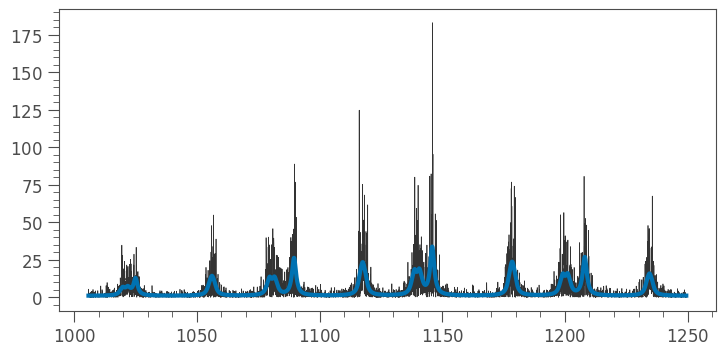

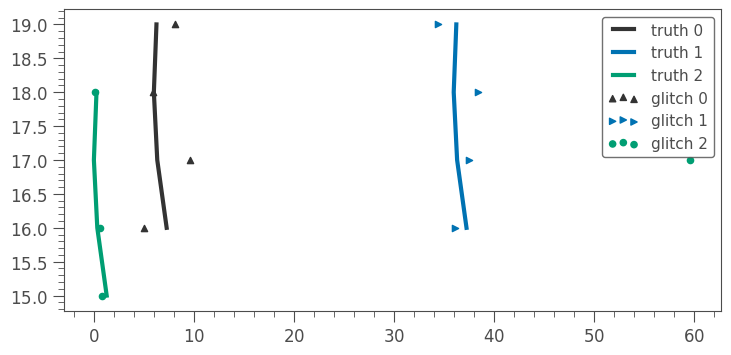

In [63]:
with plt.style.context(ms.ms):
    plt.plot(f, p)
    plt.plot(f, mod.model(init_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.scatter(f0_%deltanu_, n0_, marker='^',label='glitch 0', s=20)
    ax.scatter(f1_%deltanu_, n1_, marker='>',label='glitch 1', s=20)
    ax.scatter(f2_%deltanu_, n2_, marker='o',label='glitch 2', s=20)

    ax.plot(f0_true%deltanu_, n0_, lw=3,label='truth 0')
    ax.plot(f1_true%deltanu_, n1_, lw=3,label='truth 1')
    ax.plot(f2_true%deltanu_, n2_, lw=3,label='truth 2')

    ax.legend()
    plt.show()    

## First lets fit the mode frequencies...

In [64]:
pm_model = pm.Model()

with pm_model:   
    numax = pm.Normal('numax', numax_, 1., testval=numax_)
    deltanu = pm.Normal('deltanu', deltanu_, 1., testval=deltanu_)
    alpha = pm.Normal('alpha', alpha_, 0.001, testval=alpha_)
    epsilon = pm.Normal('epsilon', epsilon_, 1., testval=epsilon_)
    d01     = pm.Normal('d01', d01_, 0.01, testval=d01_)   
    d02     = pm.Normal('d02', d02_, 0.01, testval=d02_)
    
    sigma0 = pm.HalfNormal('sigma0', 1., testval=1.5)
    sigma1 = pm.HalfNormal('sigma1', 1., testval=2.)
    sigma2 = pm.HalfNormal('sigma2', 1., testval=.5)
    
    D0 = pm.Normal('D0', 0, 1, shape=len(f0_)) 
    D1 = pm.Normal('D1', 0, 1, shape=len(f1_)) 
    D2 = pm.Normal('D2', 0, 1, shape=len(f2_)) 
    
    f0 = pm.Deterministic('f0', D0*deltanu)
    f1 = pm.Deterministic('f1', D1*deltanu)
    f2 = pm.Deterministic('f2', D2*deltanu)
    
    pm.Normal('like0', f0, .1, observed=f0_)
    pm.Normal('like1', f1, .1, observed=f1_)
    pm.Normal('like2', f2, .1, observed=f2_)    
    
    trace = pm.sample(tune=1000,chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [D2, D1, D0, sigma2, sigma1, sigma0, d02, d01, epsilon, alpha, deltanu, numax]
Sampling 4 chains: 100%|██████████| 6000/6000 [03:40<00:00, 27.17draws/s] 
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


In [65]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
numax,1150.013199,0.985057,0.020066,1148.206114,1152.021439,2185.715375,0.999112
deltanu,60.069932,0.251963,0.013665,59.596784,60.616274,261.014588,1.000197
alpha,0.009871,0.001013,0.000021,0.007905,0.011796,2066.603573,0.999797
epsilon,1.079700,0.078557,0.004253,0.924801,1.241382,262.976336,1.000147
d01,0.500399,0.009152,0.000214,0.482281,0.517331,1935.476060,0.999393
d02,0.102354,0.008553,0.000187,0.086042,0.118566,2002.698497,0.999485
D0__0,17.063534,0.071389,0.003864,16.907788,17.197786,262.033436,1.000150
D0__1,18.138753,0.075937,0.004118,17.975312,18.280591,261.689365,1.000135
D0__2,19.076403,0.079878,0.004330,18.904568,19.227377,261.693582,1.000178
D0__3,20.111433,0.084092,0.004561,19.925738,20.266323,261.649232,1.000196


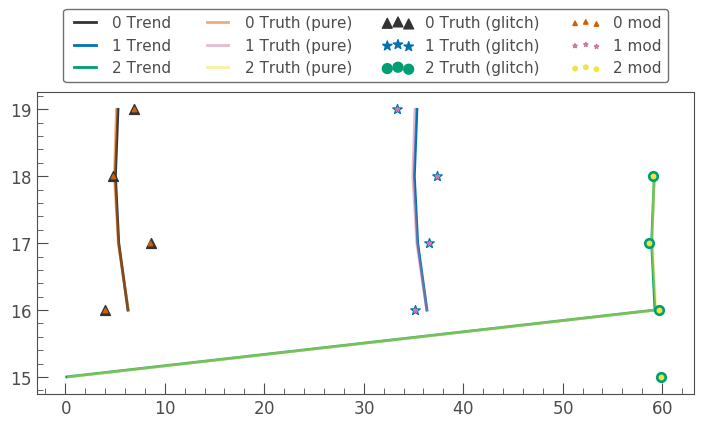

In [69]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'deltanu', 'alpha', 'epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
       
    ax.plot(mod.f0(res)*res[1]%res[1], n0_, label='0 Trend',lw=2, zorder=1)
    ax.plot(mod.f1(res)*res[1]%res[1], n1_, label='1 Trend',lw=2, zorder=1)
    ax.plot(mod.f2(res)*res[1]%res[1], n2_, label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_%res[1], n0_, marker='^',label='0 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f1_%res[1], n1_, marker='*',label='1 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f2_%res[1], n2_, marker='o',label='2 Truth (glitch)',  s=50, zorder=2)   
    
    ax.plot(f0_true%res[1], n0_, alpha=.5, label='0 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f1_true%res[1], n1_, alpha=.5, label='1 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f2_true%res[1], n2_, alpha=.5, label='2 Truth (pure)',  lw=2, zorder=1)      
    
    ax.scatter(resls[0]%res[1], n0_, marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(resls[1]%res[1], n1_, marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(resls[2]%res[1], n2_, marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))    

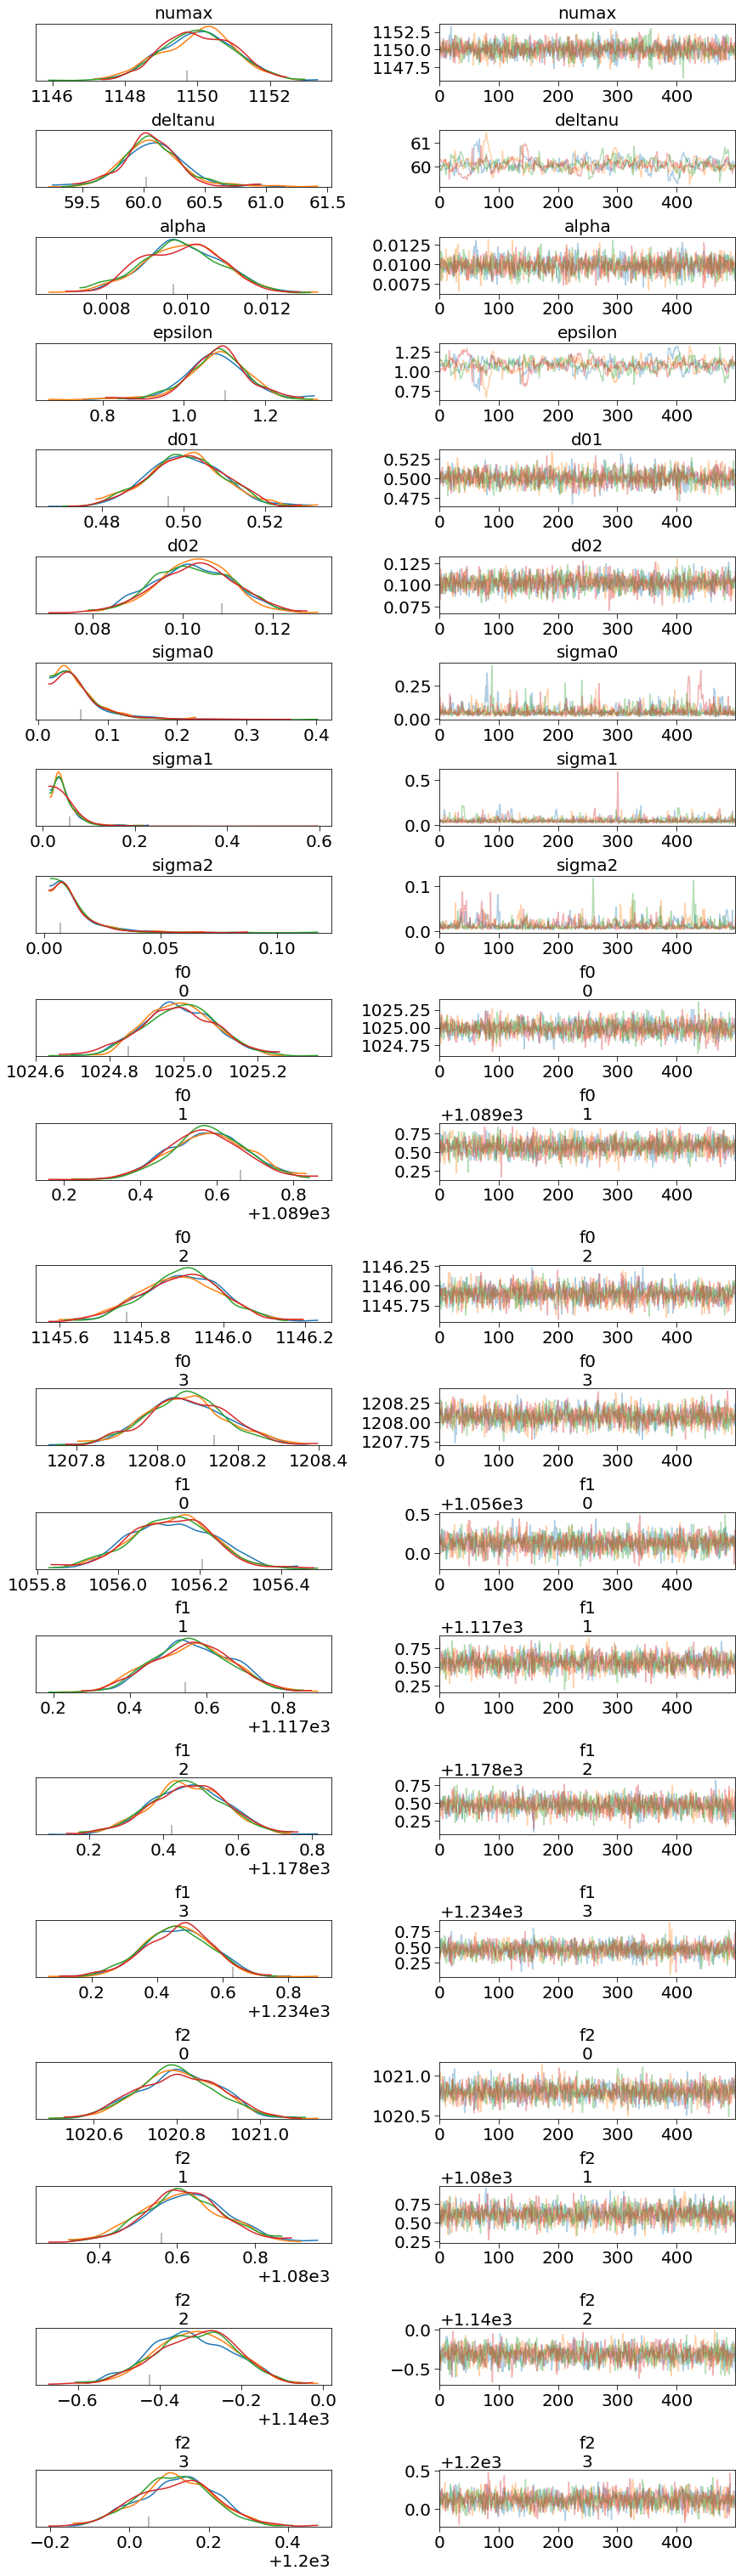

In [70]:
pm.traceplot(trace, var_names=['numax','deltanu','alpha','epsilon','d01','d02','sigma0','sigma1','sigma2',
                              'f0','f1','f2']);

# Now lets try and fit this

In [ ]:
pm_model = pm.Model()

BNormal = pm.Bound(pm.Normal, lower=0.)

with pm_model:   
    numax = pm.Normal('numax', numax_, 1., testval=numax_)
    deltanu = pm.Normal('deltanu', deltanu_, 1., testval=deltanu_)
    alpha = pm.Normal('alpha', alpha_, 0.001, testval=alpha_)
    epsilon = pm.Normal('epsilon', epsilon_, 1., testval=epsilon_)
    d01     = pm.Normal('d01', d01_, 0.01, testval=d01_)   
    d02     = pm.Normal('d02', d02_, 0.01, testval=d02_)
    
    sigma0 = pm.HalfNormal('sigma0', 1., testval=1.5)
    sigma1 = pm.HalfNormal('sigma1', 1., testval=2.)
    sigma2 = pm.HalfNormal('sigma2', 1., testval=.5)

    D0 = pm.Normal('D0', mod.f0([numax, deltanu, alpha, epsilon, d01, d02]), 1, shape=len(f0_))
    D1 = pm.Normal('D1', mod.f1([numax, deltanu, alpha, epsilon, d01, d02]), 1, shape=len(f0_))
    D2 = pm.Normal('D2', mod.f2([numax, deltanu, alpha, epsilon, d01, d02]), 1, shape=len(f0_))
    
    f0 = pm.Deterministic('f0', D0*sigma0)
    f1 = pm.Deterministic('f1', D1*sigma1)
    f2 = pm.Deterministic('f2', D2*sigma2)

#     f0 = pm.Normal('f0', mod.f0([numax, deltanu, alpha, epsilon, d01, d02]), sigma0, shape=len(f0_))
#     f1 = pm.Normal('f1', mod.f1([numax, deltanu, alpha, epsilon, d01, d02]), sigma1, shape=len(f0_))
#     f2 = pm.Normal('f2', mod.f2([numax, deltanu, alpha, epsilon, d01, d02]), sigma2, shape=len(f0_))

    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init_m[3], shape=len(init_m[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init_m[4], shape=len(init_m[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init_m[5], shape=len(init_m[5]))

    a0 = pm.HalfNormal('a0', sigma=20., testval=init_m[6], shape=len(init_m[6]))
    a1 = pm.HalfNormal('a1', sigma=20., testval=init_m[7], shape=len(init_m[7]))
    a2 = pm.HalfNormal('a2', sigma=20., testval=init_m[8], shape=len(init_m[8]))
    
    h0 = pm.Deterministic('h0', 2*a0**2/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1**2/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2**2/np.pi/g2)
    
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[9] * np.sin(init_m[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init_m[10]))
    
    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))
    
    b = BNormal('b', mu=1., sigma=.1, testval=1.)
    
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)

In [ ]:
with pm_model:
    trace = pm.sample(tune=1000, chains=4)

In [ ]:
pm.summary(trace)

In [ ]:
labels = ['numax','deltanu','alpha','epsilon','d01','d02',
          'split','i','b','xsplit','cosi','sigma0','sigma1','sigma2']
chain = np.array([trace[label] for label in labels])
truths = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_,
         init_m[9], init_m[10], init_m[11], init_m[9]*np.sin(init_m[10]), np.cos(init_m[10]),
         sigma0_, sigma1_, sigma2_]
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[.16, .5, .84], show_titles=True)
plt.show()

In [ ]:
with plt.style.context(ms.ms):
    res_m = [np.median(trace[label], axis=0) for label in ['f0','f1','f2','g0','g1','g2',
                                                         'h0','h1','h2','split','i','b']]
    plt.plot(f, p)
    plt.plot(f, mod.model(res_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax','deltanu','alpha','epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
       
    ax.plot(mod.f0(res)%res[1], n0_, label='0 Trend',lw=2, zorder=1)
    ax.plot(mod.f1(res)%res[1], n1_, label='1 Trend',lw=2, zorder=1)
    ax.plot(mod.f2(res)%res[1], n2_, label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_%res[1], n0_, marker='^',label='0 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f1_%res[1], n1_, marker='*',label='1 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f2_%res[1], n2_, marker='o',label='2 Truth (glitch)',  s=50, zorder=2)   
    
    ax.plot(f0_true%res[1], n0_, alpha=.5, label='0 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f1_true%res[1], n1_, alpha=.5, label='1 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f2_true%res[1], n2_, alpha=.5, label='2 Truth (pure)',  lw=2, zorder=1)      
    
    ax.scatter(resls[0]%res[1], n0_, marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(resls[1]%res[1], n1_, marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(resls[2]%res[1], n2_, marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))    

In [ ]:
residual = p/mod.model(res_m, theano=False)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
plt.legend()

## Let's investigate the divergences:

In [17]:
def pairplot_divergence(x, y, trace, ax=None, divergence=True, color='C3', divergence_color='C2'):
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(x, y, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(x[divergent], y[divergent], 'o', color=divergence_color)
    return ax

def divergence_corner(trace, labels, entry=0):
    chain = np.array([trace[label] for label in labels])
    if len(chain.shape) > 2:
        chain = chain[:,:,entry]
        print('Only showing the entry [{}] for multi-parameter labels'.format(entry))
        titleadd = '[{}]'.format(entry)
    else:
        titleadd = ''
    
    K = len(chain)
    factor = 2.0           # size of one side of one panel
    lbdim = 0.5 * factor   # size of left/bottom margin
    trdim = 0.2 * factor   # size of top/right margin
    whspace = 0.05         # w/hspace size
    plotdim = factor * K + factor * (K - 1.) * whspace
    dim = lbdim + plotdim + trdim

    # Create a new figure if one wasn't provided.
    fig, axes = plt.subplots(K, K, figsize=(dim, dim))

    lb = lbdim / dim
    tr = (lbdim + plotdim) / dim
    fig.subplots_adjust(left=lb, bottom=lb, right=tr, top=tr,
                        wspace=whspace, hspace=whspace)

    hist_kwargs = dict()
    hist_kwargs["color"] = hist_kwargs.get("color", 'k')
    for i, x in enumerate(chain):
        ax = axes[i,i]
        bins_1d = int(max(1, 20.))
        n, _, _ = ax.hist(x, bins=bins_1d, histtype='step')       


        title = "{}{}".format(labels[i], titleadd)
        ax.set_title(title)    

        for j, y in enumerate(chain):
            ax = axes[i, j]

            if j > i:    
                ax.set_frame_on(False)
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            elif j == i:
                ax.set_xticks([])
                ax.set_yticks([])            
                continue    

            ax = pairplot_divergence(y, x, trace, ax=ax)

            if i < K - 1:
                ax.set_xticklabels([])
            if j > 0:
                ax.set_yticklabels([])   

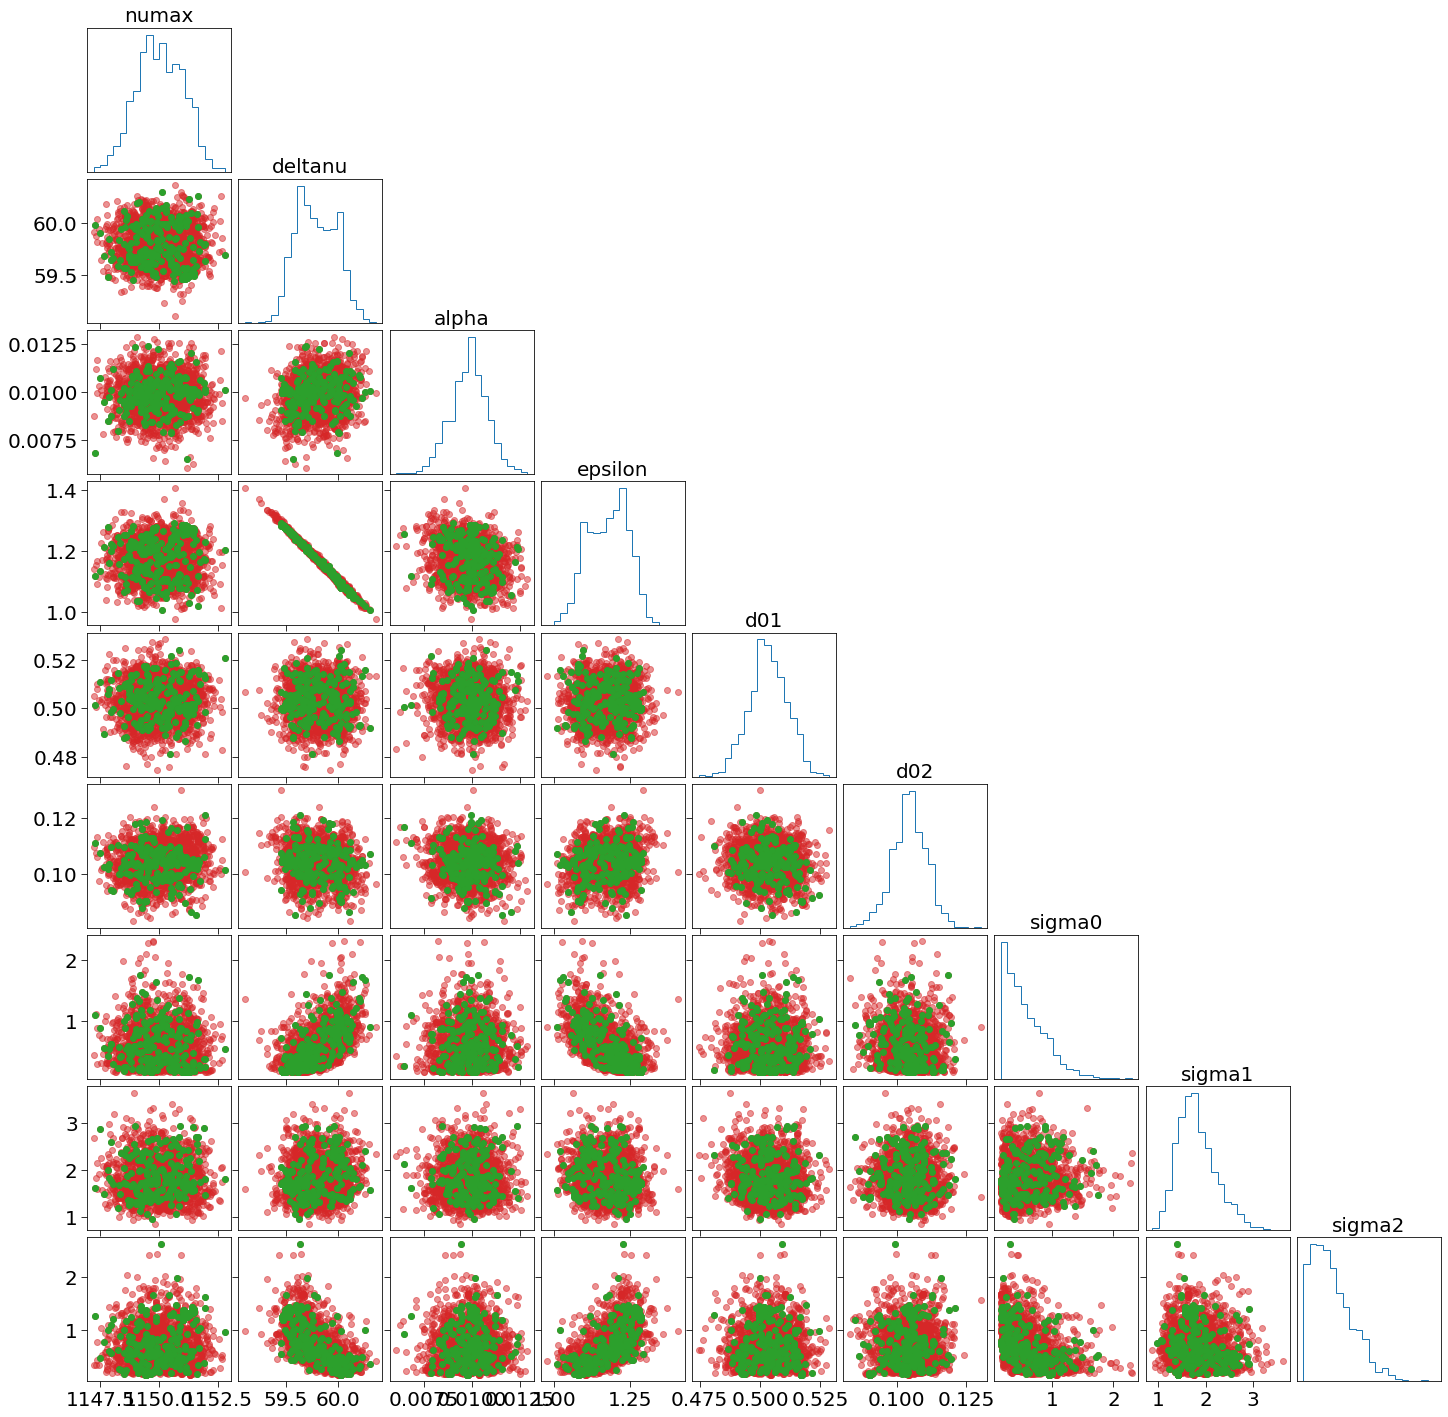

In [19]:
labels = ['numax','deltanu','alpha','epsilon','d01','d02',
          'split','i','b','xsplit','cosi','sigma0','sigma1','sigma2']
divergence_corner(trace, labels)

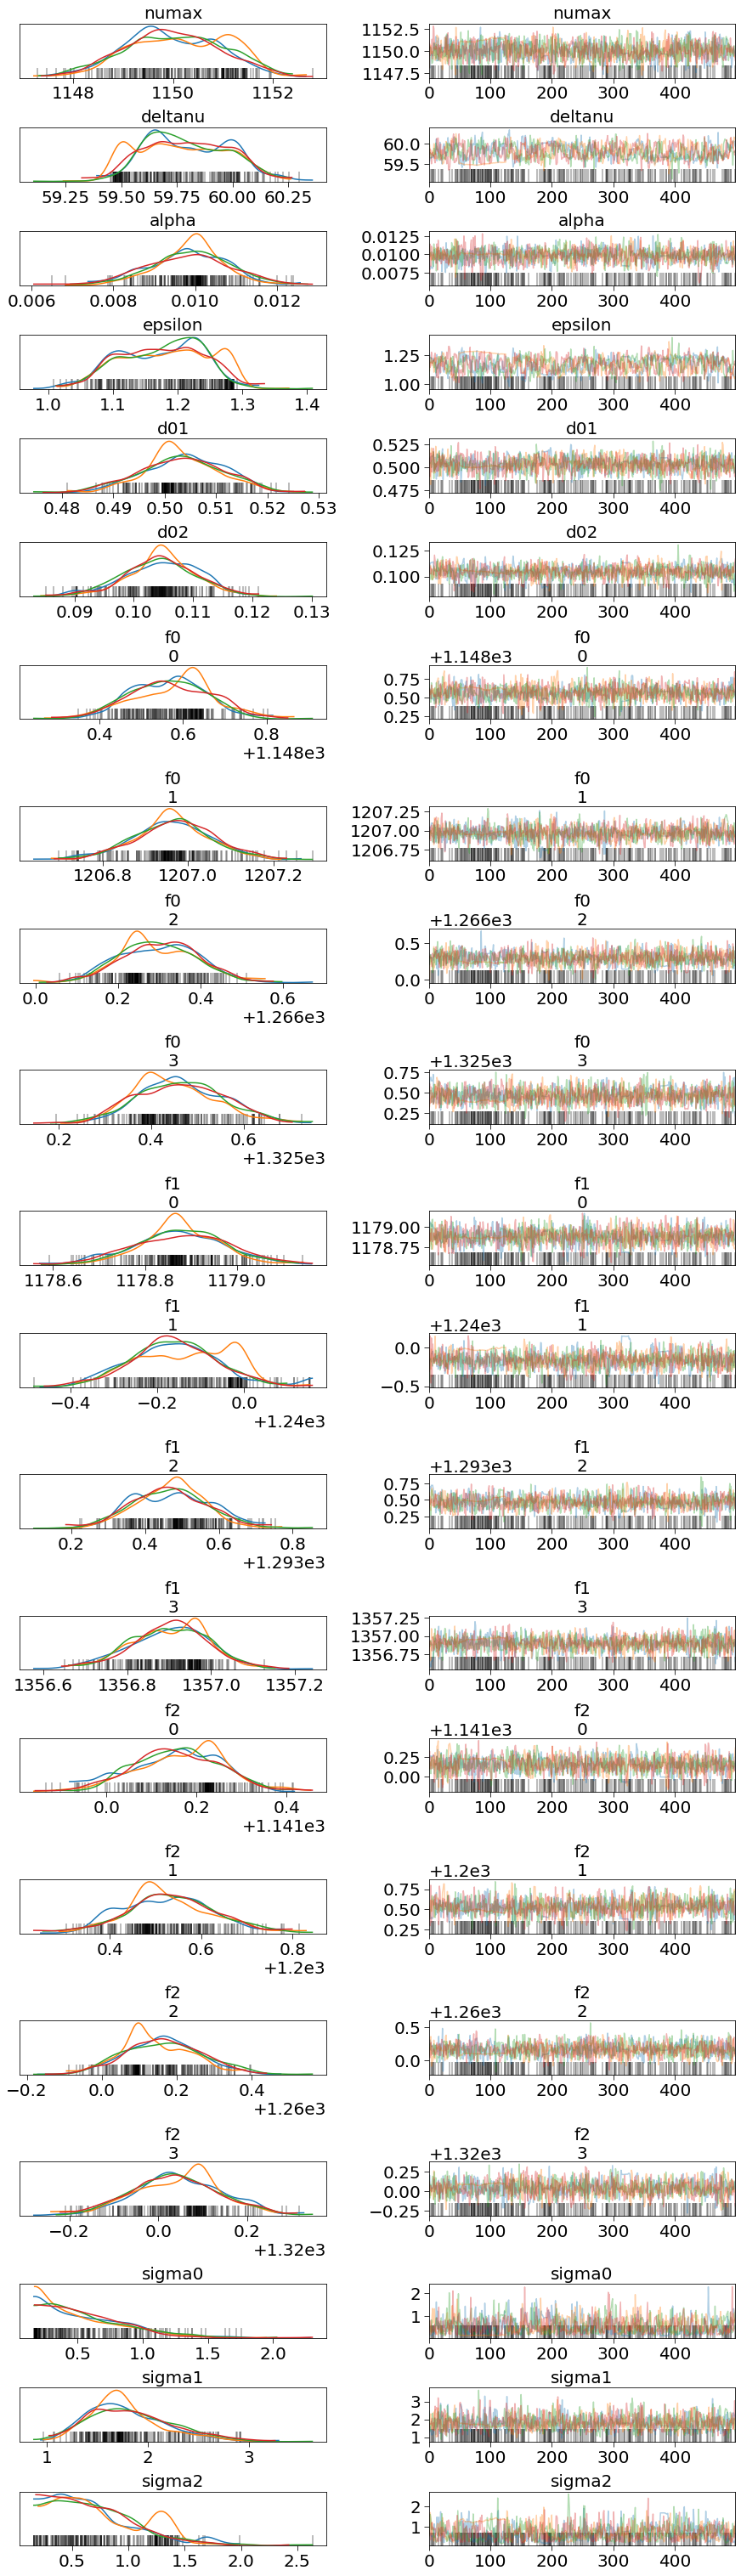

In [20]:
pm.traceplot(trace)
plt.show()